# 階層ベイズモデル

In [4]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '4'
os.environ['PYTENSOR_FLAGS'] = 'blas.ldflags=-lopenblas'


import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.impute import KNNImputer
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import pymc as pm
import arviz as az
from graphviz import Digraph

In [8]:
filepath = '../../data/raw/df.xlsx'
df = pd.read_excel(filepath)

df['population'] = pd.to_numeric(df['population'], errors='coerce')

df.head()

,island,year,island_id,region_code,region,prefecture_code,pref,population,dummy_has_bridge,dummy_connect_mainland_by_bridge,bridge_opened_year,dummy_after_bridge_build,connect_mainland_year,dummy_after_connect_mainland,income
0,島後,2001,0,NaN,隠岐の島町,32,島根県,17930.0,0,0,0,0,0,0,NaN
1,島後,2002,0,NaN,隠岐の島町,32,島根県,17865.0,0,0,0,0,0,0,NaN
2,島後,2003,0,NaN,隠岐の島町,32,島根県,17704.0,0,0,0,0,0,0,NaN
3,島後,2004,0,NaN,隠岐の島町,32,島根県,17535.0,0,0,0,0,0,0,NaN
4,島後,2005,0,32528.0,隠岐の島町,32,島根県,17259.0,0,0,0,0,0,0,19083931.0


## モデリング

### 尤度
$$
y_{it} \sim Poisson(\lambda_{it}) \\
$$

線形予測子
$$
\lambda_{it} = \exp(\alpha + \beta_{1}bridge_{it} + \beta_{2}income{it} + \gamma_{i} + \delta_{t}) \\
$$

### 事前分布

#### 固定効果

$$
\alpha \sim Normal(0, 100) \\
\beta_{1} \sim Normal(0, 100) \\
\beta_{2} \sim Normal(0, 100) \\
$$



#### ランダム効果

島効果
$$
\gamma_{i} \sim N(0, \sigma_{\gamma}^{2}) \\
$$

年効果
$$
\delta_{t} \sim N(0, \sigma_{\delta}^{2}) \\
$$

#### ハイパーパラメータ

$$
\sigma_{\gamma} \sim HalfStudentT(4, 0, 100) \\
\sigma_{\delta} \sim HalfStudentT(4, 0, 100) \\
$$

In [13]:
# 2次元データに変換

population_pivot_table = df.pivot(index='island_id', columns='year', values='population')
population_2d = population_pivot_table

bridge_pivot_table = df.pivot(index='island_id', columns='year', values='dummy_after_bridge_build')
bridge_2d = bridge_pivot_table

income_pivot_table = df.pivot(index='island_id', columns='year', values='income')
income_2d = income_pivot_table
log_income_2d = np.log(income_2d)

N_islands = df['island_id'].nunique()
N_years = df['year'].nunique()

In [14]:
# 欠損値の位置を特定
missing_mask = np.isnan(population_2d)

# 欠損値をK近傍法で補完
imputer = KNNImputer(n_neighbors=5)
population_2d_filled = imputer.fit_transform(population_2d)

In [21]:
population_2d_filled.shape

(155, 37)

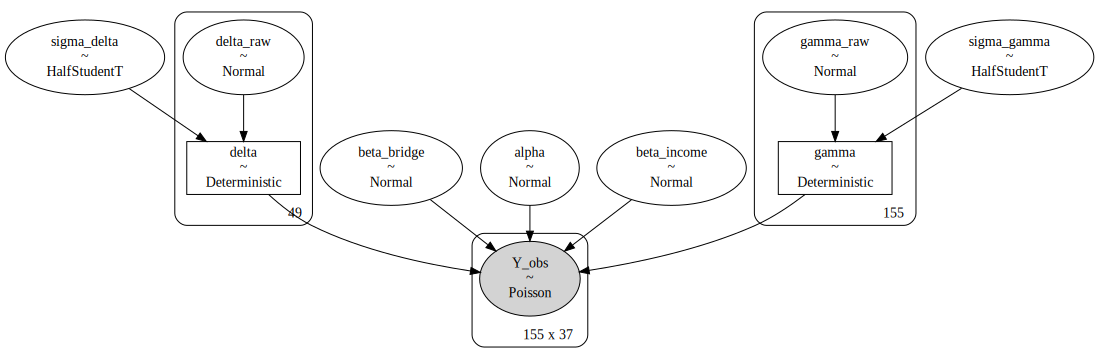

In [18]:
with pm.Model() as model:
    # ハイパーパラメータ
    sigma_gamma = pm.HalfStudentT('sigma_gamma', nu=4, sigma=100)
    sigma_delta = pm.HalfStudentT('sigma_delta', nu=4, sigma=100)

    # 固定効果の事前分布
    alpha = pm.Normal('alpha', mu=0, sigma=100)
    beta_bridge = pm.Normal('beta_bridge', mu=0, sigma=100)
    beta_income = pm.Normal('beta_income', mu=0, sigma=100)

    # 非中心化されたランダム効果
    gamma_raw = pm.Normal('gamma_raw', mu=0, sigma=1, shape=N_islands)
    delta_raw = pm.Normal('delta_raw', mu=0, sigma=1, shape=N_years)
    gamma = pm.Deterministic('gamma', gamma_raw * sigma_gamma)
    delta = pm.Deterministic('delta', delta_raw * sigma_delta)

    # linear model
    lambda_ = pm.math.exp(alpha + beta_bridge * bridge_2d + beta_income * log_income_2d + gamma[:, np.newaxis] + delta[np.newaxis, :])

    # Likelihood
    Y_obs = pm.Poisson('Y_obs', mu=lambda_, observed=population_2d_filled)

# モデルの可視化
graph = pm.model_to_graphviz(model)
graph.render(filename='../visualization/graphviz/hierarchical_bayeisan_model', format='png', cleanup=True)
graph

## サンプリング

In [17]:
with model:
    idata = pm.sample(
        draws=10000,
        tune=5000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
        chains=4,
    )


ValueError: Incompatible Elemwise input shapes [(155, 37), (155, 49)]

In [12]:
az.to_netcdf(idata, 'poisson_bridge_income_hierarchical.nc')

'poisson_bridge_income_hierarchical.nc'

In [ ]:
az.plot_trace(idata, figsize=(14, 10))  # サイズを調整
az.summary(idata)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite val

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.114,0.398,-0.534,0.397,0.199,0.152,4.0,4.0,3097113.03
beta_bridge,0.326,0.438,-0.334,0.845,0.219,0.168,4.0,4.0,3097113.03
beta_income,-0.728,0.099,-0.859,-0.590,0.049,0.038,4.0,4.0,3097113.03
gamma_raw[0],0.374,0.691,-0.776,0.933,0.345,0.265,4.0,4.0,3097113.03
gamma_raw[1],0.047,0.600,-0.816,0.863,0.300,0.230,4.0,4.0,3097113.03
...,...,...,...,...,...,...,...,...,...
delta[19],24.524,46.329,-30.134,88.606,23.155,17.741,4.0,4.0,3097113.03
delta[20],15.572,26.639,-17.462,51.178,13.314,10.201,4.0,4.0,3097113.03
delta[21],-13.464,30.421,-53.686,17.847,15.204,11.649,4.0,4.0,2462046.92
delta[22],-26.459,63.760,-134.299,26.419,31.867,24.416,4.0,4.0,3097113.03


Error in callback <function _draw_all_if_interactive at 0x7f57c4946320> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 